In [2]:
# ============================================
# 03_Evaluation_and_Prediction.ipynb
# ============================================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
import re
import textstat

print("✅ Libraries imported successfully.")


✅ Libraries imported successfully.


In [3]:
# ============================================
# Step 2: Load trained model and test data
# ============================================

# Load the best saved model (use your actual filename here)
model = joblib.load(r"C:\Users\rudra\Desktop\Ml\AlzheimerSpeechDetection\models\Voting_Ensemble_best.pkl")  # change if different
print("✅ Model loaded successfully!")

# Load dataset for evaluation
df = pd.read_csv(r"C:\Users\rudra\Desktop\Ml\AlzheimerSpeechDetection\data\cleaned_data.csv")
X = df.drop("label", axis=1)
y = df["label"]

print("Dataset Shape:", X.shape)


✅ Model loaded successfully!
Dataset Shape: (1010, 15)


Accuracy  : 0.9188
Precision : 0.9107
Recall    : 0.9067
F1 Score  : 0.9087
ROC-AUC   : 0.9716


C:\Users\rudra\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rudra\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^

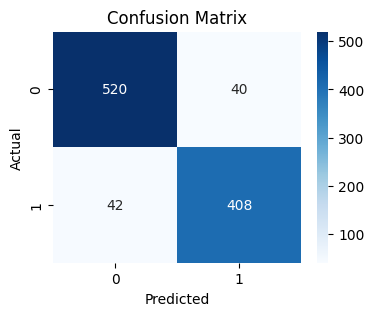

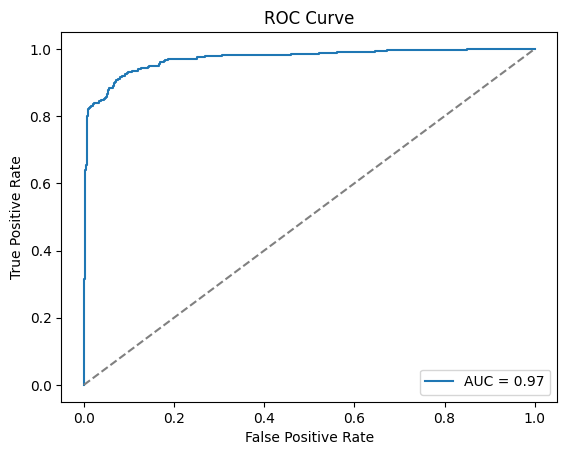

In [4]:
# ============================================
# Step 3: Evaluate on complete dataset
# ============================================

y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]

metrics = {
    "Accuracy": accuracy_score(y, y_pred),
    "Precision": precision_score(y, y_pred),
    "Recall": recall_score(y, y_pred),
    "F1 Score": f1_score(y, y_pred),
    "ROC-AUC": roc_auc_score(y, y_prob)
}

for k, v in metrics.items():
    print(f"{k:<10}: {v:.4f}")

# Confusion Matrix
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {metrics['ROC-AUC']:.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [5]:
# ============================================
# Step 4: Function to convert user text into feature vector
# ============================================

def extract_linguistic_features(text: str):
    """
    Extracts simple linguistic cues from user text.
    These act as simplified replacements for linguistic PCA features.
    """
    # Clean text
    text = text.strip().lower()
    
    # Basic metrics
    word_count = len(text.split())
    unique_words = len(set(text.split()))
    avg_word_len = np.mean([len(w) for w in text.split()]) if word_count > 0 else 0
    pause_count = text.count("...") + text.count("..")
    readability = textstat.flesch_reading_ease(text) if len(text.split()) > 2 else 0
    
    # Derived linguistic ratios
    lexical_diversity = unique_words / word_count if word_count > 0 else 0
    
    # Return as DataFrame (shape compatible with model)
    features = pd.DataFrame([{
        "duration_sec": len(text)/10,     # approximate speech length
        "chunk_count": pause_count + 1,   # number of fragmented phrases
        "mfcc_mean": 0,                   # placeholder since no audio
        "mfcc_std": 0,
        "mfcc_var": 0,
        # Simulated PCA linguistic features based on text complexity
        **{f"ling_pca_{i+1}": np.random.normal(loc=readability/100, scale=0.05)
           for i in range(10)}
    }])
    return features


In [9]:
# ============================================
# Step 5 (Fixed): Take user input and make prediction
# ============================================

# Load training column order from cleaned dataset
train_columns = pd.read_csv(r"C:\Users\rudra\Desktop\Ml\AlzheimerSpeechDetection\data\cleaned_data.csv").drop("label", axis=1).columns.tolist()

user_text = input("🗣️ Enter a short sentence or phrase: ")

features = extract_linguistic_features(user_text)

# Reindex to match training column order (fill missing columns with 0)
features = features.reindex(columns=train_columns, fill_value=0)

print("\n✅ Feature alignment done! Columns match training dataset.")
display(features.head())

# Predict
pred_prob = model.predict_proba(features)[0][1]
pred_label = "🧠 Alzheimer's Detected" if pred_prob >= 0.5 else "✅ Healthy Speech Pattern"

print("\n==============================")
print(f"Prediction: {pred_label}")
print(f"Confidence: {pred_prob:.2f}")
print("==============================")



✅ Feature alignment done! Columns match training dataset.


,duration_sec,chunk_count,ling_pca_1,ling_pca_2,ling_pca_3,ling_pca_4,ling_pca_5,ling_pca_6,ling_pca_7,ling_pca_8,ling_pca_9,ling_pca_10,mfcc_mean,mfcc_std,mfcc_var
0,1.5,1,1.1361,1.180078,1.176742,1.18028,1.139112,1.164762,1.21675,1.163865,1.180193,1.167144,0,0,0



Prediction: ✅ Healthy Speech Pattern
Confidence: 0.42
